# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [6]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [7]:
train = train.fillna("")
test = test.fillna("")

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [8]:
ten_keywords = train['keyword'].value_counts().sort_values(ascending=False)[:10].index
filtered_train = train.loc[train.keyword.isin(ten_keywords)]

0    3024
1    2305
Name: target, dtype: int64


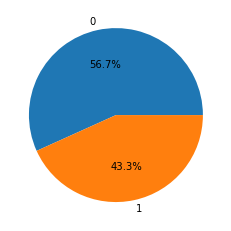

In [9]:
classes = train['target'].value_counts()
print(classes)
plt.pie(classes, labels=classes.index, autopct='%.1f%%');

In [10]:
df = filtered_train.groupby('keyword')['target'].mean()
df

keyword
                     0.727273
damage               0.472222
deluge               0.161290
derail               0.500000
fatalities           0.484848
harm                 0.133333
nuclear%20reactor    0.400000
refugees             0.566667
siren                0.114286
wreckage             1.000000
Name: target, dtype: float64

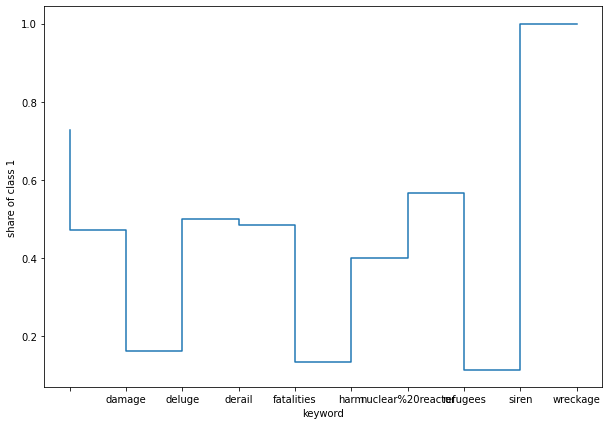

In [11]:
plt.figure(figsize=(10,7))
plt.step(df.index, df.values)
plt.xlabel('keyword')
plt.ylabel('share of class 1')
plt.show()

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [12]:
new_train = train.copy()
new_test = test.copy()
new_train['text_column'] = new_train['keyword'] + ' ' + new_train['location'] + ' ' + new_train['text']
new_train.drop(['id', 'keyword', 'location', 'text'], axis=1)
new_test['text_column'] = new_test['keyword'] + ' ' + new_test['location'] + ' ' + new_test['text']
new_test.drop(['id', 'keyword', 'location', 'text'], axis=1)

,target,text_column
2644,1,destruction So you have a new weapon that can...
2227,0,deluge The f$&amp;@ing things I do for #GISHW...
5448,1,police UK DT @georgegalloway: RT @Galloway4May...
132,0,aftershock Aftershock back to school kick off...
6845,0,"trauma Montgomery County, MD in response to tr..."
...,...,...
4307,0,"hellfire 570 Vanderbilt; Brooklyn, NY New cock..."
3375,1,evacuation USA Bend Post Office roofers cut ga...
1710,1,collided Monsoon flooding - Monsoon rains hav...
4898,1,massacre Ireland Remember this was a massacre ...


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(new_train['text_column'])
X.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [14]:
import re
from string import punctuation
punc = punctuation

def count_func(vec):
    vocab = vec.vocabulary_
    digit_count = 0
    punc_count = 0
    hashtag_count = 0
    mention_count = 0
    for elem in vocab.keys():
        if re.search(r'\d', elem):
            digit_count += 1
        if set(elem).isdisjoint(punc) == False:
            punc_count += 1
        if elem.startswith('#'):
            hashtag_count += 1
        if elem.startswith('@'):
            mention_count += 1
            
    return [digit_count, punc_count, hashtag_count, mention_count]

c = count_func(cnt_vec)

print(f'Number of words with digits: {c[0]}\n'
      f'Number of words with punctuation: {c[1]}\n'
      f'Number of hashtags: {c[2]}\n'
      f'Number of mentions: {c[3]}')

Number of words with digits: 3812
Number of words with punctuation: 315
Number of hashtags: 0
Number of mentions: 0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [15]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

new_cnt_vec = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
new_X = new_cnt_vec.fit_transform(new_train['text_column'])
c_tw = count_func(new_cnt_vec)

print(f'Number of words with digits: {c_tw[0]}\n'
      f'Number of words with punctuation: {c_tw[1]}\n'
      f'Number of hashtags: {c_tw[2]}\n'
      f'Number of mentions: {c_tw[3]}')

Number of words with digits: 3939
Number of words with punctuation: 7338
Number of hashtags: 1470
Number of mentions: 1679


In [16]:
new_X.shape
# размер матрицы увеличился

(5329, 19670)

In [17]:
d = {'Without TweetTokenizer': c + [X.shape], 'With TweetTokenizer': c_tw + [new_X.shape]}
pd.DataFrame(data=d, index=['Number of words with digits', 'Number of words with punctuation', 
                            'Number of hashtags', 'Number of mentions', 'Shape' ])

,Without TweetTokenizer,With TweetTokenizer
Number of words with digits,3812,3939
Number of words with punctuation,315,7338
Number of hashtags,0,1470
Number of mentions,0,1679
Shape,"(5329, 18455)","(5329, 19670)"


## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [18]:
from nltk.stem.snowball import SnowballStemmer
import nltk


def smile(t):
    if set(t).issubset(punc) and re.search(r'[()]', t):
        return True
    return False

def ok_token(token):
    if (token.isalpha() or smile(token) or re.fullmatch(r'[#][a-z]+', token)) \
    and token not in nltk.corpus.stopwords.words('english'):
        return True
    return False


def custom_tokenizer(text):
    text = text.lower()
    tw = TweetTokenizer()
    text_tokenized = [w for w in tw.tokenize(text) if ok_token(w)]
    stemmer = SnowballStemmer('english')
    text_stemmed = [stemmer.stem(w) for w in text_tokenized]
    return text_stemmed


In [19]:
for elem in new_train['text_column'][:10]:
    print(elem)
    print(custom_tokenizer(elem))
    print('\n')

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
['bridg', 'ash', 'australia', 'ûªs', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']


hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']


police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']


rioting  Still rioting in a couple of hours left until I have to be up for class.
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']


wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface w

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [21]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
X_custom_train = cv.fit_transform(new_train['text_column'])
X_custom_test = cv.transform(new_test['text_column'])
X_custom_train.shape

(5329, 10587)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score


lr = LogisticRegression()
lr.fit(X_custom_train, new_train['target'])
lr_predict = lr.predict(X_custom_test)
f1_cv = f1_score(new_test["target"], lr_predict)
print(f'F1-score: {f1_cv}')

F1-score: 0.7516129032258064


## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(tokenizer=custom_tokenizer)
X_custom_train_2 = tf.fit_transform(new_train['text_column'])
X_custom_test_2 = tf.transform(new_test['text_column'])
X_custom_train_2.shape

(5329, 10587)

In [24]:
lr.fit(X_custom_train_2, new_train['target'])
lr_predict = lr.predict(X_custom_test_2)
f1_tfid = f1_score(new_test["target"], lr_predict)
print(f'F1-score: {f1_tfid}')
# качество немного ухудшилось

F1-score: 0.743461324429605


In [25]:
tf = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
X_custom_train_3 = tf.fit_transform(new_train['text_column'])
X_custom_test_3 = tf.transform(new_test['text_column'])
X_custom_train_3.shape
# размер не изменился

(5329, 10587)

In [26]:
lr.fit(X_custom_train_3, new_train['target'])
lr_predict = lr.predict(X_custom_test_3)
f1_tfid_max_df = f1_score(new_test['target'], lr_predict)
print(f'F1-score: {f1_tfid_max_df}')
# качество осталось прежним

F1-score: 0.743461324429605


In [27]:
best_f1 = 0
best_df = None
for df in [2, 3, 4, 5]:
    tf = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=df)
    X_custom_train_new = tf.fit_transform(new_train['text_column'])
    X_custom_test_new = tf.transform(new_test['text_column'])
    lr.fit(X_custom_train_new, new_train['target'])
    lr_predict = lr.predict(X_custom_test_new)
    f1 = f1_score(new_test["target"], lr_predict)
    if f1 > best_f1:
        best_f1 = f1
        best_df_tf = df
    print(f'F1-score (min_df={df}): {f1_score(new_test["target"], lr_predict)}')

print(f'The best min_df = {best_df_tf}')

tf = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=best_df_tf)
X_custom_train_new = tf.fit_transform(new_train['text_column'])
X_custom_test_new = tf.transform(new_test['text_column'])
lr.fit(X_custom_train_new, new_train['target'])
lr_predict = lr.predict(X_custom_test_new)
f1_tfid_min = f1_score(new_test["target"], lr_predict)

F1-score (min_df=2): 0.745969983324069
F1-score (min_df=3): 0.7434903047091412
F1-score (min_df=4): 0.7395143487858721
F1-score (min_df=5): 0.7411894273127754
The best min_df = 2


## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [28]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=5000)
X_custom_train_hv = hv.fit_transform(new_train['text_column'])
X_custom_test_hv = hv.transform(new_test['text_column'])
lr.fit(X_custom_train_hv, new_train['target'])
lr_predict = lr.predict(X_custom_test_hv)
f1_hash = f1_score(new_test["target"], lr_predict)
print(f'F1-score: {f1_hash}')
# результат ухудшился

F1-score: 0.7253481894150418


## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [29]:
for df in [2, 3, 4, 5]:
    cv = CountVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=df)
    X_custom_train_new = cv.fit_transform(new_train['text_column'])
    X_custom_test_new = cv.transform(new_test['text_column'])
    lr.fit(X_custom_train_new, new_train['target'])
    lr_predict = lr.predict(X_custom_test_new)
    f1 = f1_score(new_test["target"], lr_predict)
    if f1 > best_f1:
        best_f1 = f1
        best_df_cv = df
    print(f'F1-score (min_df={df}): {f1_score(new_test["target"], lr_predict)}')

print(f'The best min_df = {best_df_cv}')

cv = CountVectorizer(tokenizer=custom_tokenizer, max_df=0.9, min_df=best_df_cv)
X_custom_train_new = cv.fit_transform(new_train['text_column'])
X_custom_test_new = cv.transform(new_test['text_column'])
lr.fit(X_custom_train_new, new_train['target'])
lr_predict = lr.predict(X_custom_test_new)
f1_cv_min = f1_score(new_test["target"], lr_predict)

F1-score (min_df=2): 0.7510729613733905
F1-score (min_df=3): 0.7543953116675547
F1-score (min_df=4): 0.7514698022447888
F1-score (min_df=5): 0.7506702412868632
The best min_df = 3


In [30]:
# Сравнение F1-мер:
d = {'CountVectorizer F1-score': f1_cv,
    'TfidfVectorizer': f1_tfid, 
    'TfidfVectorizer (max_df=0.9)': f1_tfid_max_df,
     f'TfidfVectorizer (max_df=0.9, min_df={best_df_tf})': f1_tfid_min,
    'HashingVectorizer': f1_hash,
    f'CountVectorizer (max_df=0.9, min_df={best_df_tf})': f1_cv_min}

pd.DataFrame(data=d, index=['F1-score']).T
# самый лучший результат показал CountVectorizer при max_df=0.9, min_df=3

,F1-score
CountVectorizer F1-score,0.751613
TfidfVectorizer,0.743461
TfidfVectorizer (max_df=0.9),0.743461
"TfidfVectorizer (max_df=0.9, min_df=2)",0.745970
HashingVectorizer,0.725348
"CountVectorizer (max_df=0.9, min_df=2)",0.754395
